# Prediction with pre-trained CNNs
This notebook will give you all the code you need to use a pre-trained OpenSoundscape CNN model to make predictions on your own data. 

If you haven't installed OpenSoundscape yet, first do that by following the instructions on [opensoundscape.org](http://opensoundscape.org/)

More detailed tutorials on prediction, as well as training CNNs and preprocessing data, can be found in the other tutorial notebooks, also at [opensoundscape.org](http://opensoundscape.org/).

## Load required packages

In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import AudioToSpectrogramPreprocessor

# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import Resnet18Binary

#other utilities and packages
from opensoundscape.helpers import run_command
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

## Preparing your audio data for prediction

To run predictions on your audio data, you will need to have your audio already split up into the clip lengths that the model expects to recieve (you can check the length of clips that the model to recieves in the model's notes when you download it, this is often but not always 5.0 seconds). 

### Download audio files

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. OR download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [2]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

### generate a Preprocessor object

In addition to having the audio clips of fixed length, you will need to generate a Pandas DataFrame with the index containing the paths to each file, as shown below. You'll then use that DataFrame to creat the Preprocessor object that loads audio samples for the CNN.

NOTE: If the model was trained with any special preprocesor settings, you should apply those settings here. 

See the model's notes from its download page for the exact code to use here. 

In [3]:
# collect a list of audio files
file_list = glob('./woodcock_labeled_data/*.wav')

# create a DataFrame with the audio files as the index
audio_file_df = pd.DataFrame(index=file_list)

# create a Preprocessor object 
# we use the option "return_labels=False" because our audio to predict on does not have labels
from opensoundscape.preprocess.preprocessors import AudioToSpectrogramPreprocessor
prediction_dataset = AudioToSpectrogramPreprocessor(audio_file_df,return_labels=False)

## Generate prediction scores using a pre-trained model from OpenSoundscape 0.5.x
Check the model notes page for the appropriate model class to use. 

For the purpose of demonstration, let's generate a brand new model and save it to our local folder. If you download a pre-trained model, you can skip this cell and instead provide the `from_checkpoint()` method with the path to your downloaded model.

In [4]:
from opensoundscape.torch.models.cnn import Resnet18Binary
model = Resnet18Binary(classes=['absent','present'])
model.save('./demo.model')

created PytorchModel model object with 2 classes
Saving to demo.model


In [5]:
# load the model into the appropriate model class
model = Resnet18Binary.from_checkpoint('./demo.model')

# call model.predict() with the Preprocessor to generate predictions
scores, _, _ = model.predict(prediction_dataset)

#look at the scores of the first 5 samples
scores.head()

created PytorchModel model object with 2 classes
loading weights from saved object
(29, 2)


,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0.932643,-0.216228
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1.230987,-0.006635
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,1.487079,0.099965
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,1.509498,-0.033766
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,1.164623,-0.255705


### Options for prediction

the code above returns the raw predictions of the model without any post-processing (such as a softmax or sigmoid layer). 

For more details on how to use the predict() function to generate scores and binary 0/1 predictions of class presence, see the "Basic training and prediction with CNNs" tutorial notebook. 

As a quick example, we could generate scores using a softmax then logit layer, and simultaneously generate single-label 0/1 predictions, like this:

In [6]:
scores, binary_predictions, _ = model.predict(prediction_dataset,activation_layer='softmax_and_logit',binary_preds='single_target')

(29, 2)


Now, the scores DataFrame has had a softmax layer applied, followed by a logit transform (which maps values on [0,1] to [-inf, +inf])

In [7]:
scores.head(2)

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,1.148870,-1.148870
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1.237622,-1.237622


We also have the binary 0/1 ("absent" vs "present") predictions generated by the model:

In [8]:
binary_predictions.head(2)

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,1.0,0.0
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1.0,0.0


We could also look a histogram of the scores for the positive class

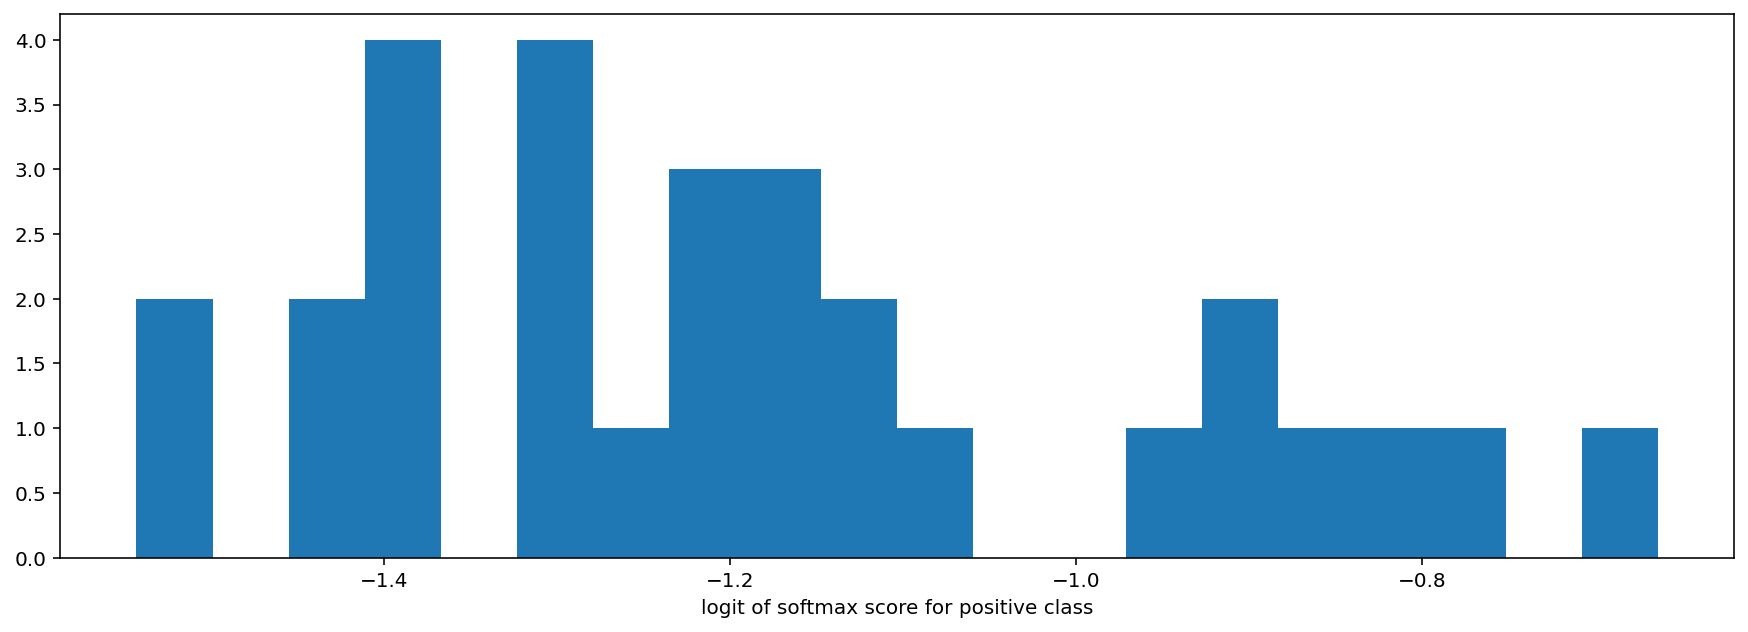

In [9]:
_ = plt.hist(scores['present'],bins=20)
_ = plt.xlabel('logit of softmax score for positive class')

## Using a pre-trained model from OpenSoundscape 0.4.x
One set of our publicly availably [binary models for 500 species](https://pitt.app.box.com/s/3048856qbm9x55yi3zfksa3fide5uuf4) were created with an older version of OpenSoundscape and require a little bit of manipulation to load into OpenSoundscape 0.5.x onward.

First, let's download one of these models (it's stored in a .tar format) and save it to the same directory as this notebook in a file called `opso_04_model_acanthis-flammea.tar`

In [10]:
%%bash
curl -L https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar -o ./opso_04_model_acanthis-flammea.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      6      0 --:--:--  0:00:01 --:--:--     9
100 42.9M  100 42.9M    0     0  3747k      0  0:00:11  0:00:11 --:--:-- 5289k


Next, lets load the weights from that model into an Opensoundscape model object. 

In [11]:
from opensoundscape.torch.models.cnn import PytorchModel
from opensoundscape.torch.architectures.cnn_architectures import resnet18
import torch

# load the tar file into a dictionary 
# (you could change this to the location of any .tar file on your computer)
opso_04_model_tar_path = "./opso_04_model_acanthis-flammea.tar"
opso_04_model_dict = torch.load(opso_04_model_tar_path)

# create a resnet18 binary model 
# (all models created with Opensoundscape 0.4.x are 2-class resnet18 architectures)
architecture = resnet18(num_classes=2,use_pretrained=False)
model = PytorchModel(classes=['negative','positive'],architecture=architecture)

# load the model weights into our model object
# now, our model is equivalent to the trained model we downloaded
model.network.load_state_dict(opso_04_model_dict['model_state_dict'])

created PytorchModel model object with 2 classes


<All keys matched successfully>

now, we can use the model as normal to create predictions on audio. We'll use the same `prediction_dataset` from above. 

Remember to choose the `activation_layer` carefully, and think about whether you need binary_preds=`single_target` or `multi_target` if you want to generate 0/1 predictions for each sample and class. 

In this example, we'll assume we just want to generate scores, not binary predictions. We'll apply a softmax layer, then the logit transform, to the scores using the `activation_layer="softmax_and_logit"` option - this will generate the type of scores that are useful for plotting score histograms, among other things. 

In [12]:
# generate predictions on our dataset
predition_scores_df,_,_ = model.predict(prediction_dataset, activation_layer='softmax_and_logit')

predition_scores_df.head(3)

(29, 2)


,negative,positive
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,3.953401,-3.953401
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,3.650462,-3.650461
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,2.165401,-2.165401


### clean up
remove files

In [14]:
from glob import glob
for p in glob('./woodcock_labeled_data/*'):
    Path(p).unlink()
for p in glob('./*.model'):
    Path(p).unlink()
for p in glob('./*.tar'):
    Path(p).unlink()